In [1]:
import os
from collections import OrderedDict 
import matplotlib.pyplot as plt    

import numpy as np
from astropy.io import fits
from astropy.modeling import models
from skimage.morphology import label
import astropy.io.fits as pyfits
import astropy.wcs as pywcs
import grizli
import grizli.model
import grizli.fake_image
workdir = '/hpc/group/cosmology/zg64/package-repo/Roman_grism_sim'
if os.path.exists(workdir):
    os.chdir(workdir)

### Create a fake direct image and seg map

In [2]:
# make fake grism image (just noise) first to get the header

NEXP =   10  # divided between 10 exposures
EXPTIME = 347*NEXP # 10 ks ~ 4 HST orbits
ra, dec = 53.1592277508136, -27.782056346146


h, wcs =grizli.fake_image.roman_header(ra=ra, dec=dec, pa_aper=0, naxis=(1024,1024))
grizli.fake_image.make_fake_image(h, output='roman_example_flt.fits', exptime=EXPTIME, nexp=NEXP)



 [astropy.io.fits.verify]


[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f494c77e370>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f4915cdc580>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f4915cdc430>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f4915cdc520>]

In [3]:
def get_counts(mag):
    counts = np.power(10, -0.4 * (mag - ZP))
    return counts

dirimage = 'roman_grism_test_dirimg.fits'
segfile = dirimage.replace('dirimg.fits', 'segmap.fits')
NPIX = 1024
ZP = 26.3
mag1, mag2 = 21.0, 20.5
exptime = 3600

# First create direct image and segfile
full_img = np.zeros((NPIX, NPIX))
# Create Gaussian function models
# stddev in pixels
gaussfunc1 = models.Gaussian2D(x_stddev=5, y_stddev=5)
gaussfunc2 = models.Gaussian2D(x_stddev=5, y_stddev=5)

# Put the two galaxies at predetermined locations
gaussfunc1.x_mean = 300
gaussfunc1.y_mean = 500
gaussfunc2.x_mean = 100
gaussfunc2.y_mean = 800

x, y = np.meshgrid(np.arange(NPIX), np.arange(NPIX))
full_img += gaussfunc1(x, y)
full_img += gaussfunc2(x, y)

# Get required coutns
counts1 = get_counts(mag1)
counts2 = get_counts(mag2)
all_counts = [counts1, counts2]

# Generate segmap
threshold = 0.3  # threshold to apply to the image
good = full_img > threshold  # these pixels belong to a source
segmap = label(good)  # now these pixels have unique SegIDs

nonzero_idx = np.where(segmap != 0)
segids = np.sort(np.unique(segmap[nonzero_idx]))

for i in range(len(segids)):
    segid = segids[i]
    segidx = np.where(segmap == segid)
    src_counts = np.sum(full_img[segidx])
    counts = all_counts[i]
    # scale
    scale_fac = counts / src_counts
    full_img[segidx] *= scale_fac

# Save
# Create a header using header from grism flt file to get the correct WCS
dirimg_hdr = fits.getheader('roman_example_flt.fits')
hdr = dirimg_hdr

# delete some keywords from grism flt header
del hdr['PHOTFLAM']
del hdr['PHOTPLAM']
ihdul = fits.HDUList()

ext_sci = fits.ImageHDU(data=full_img, header=hdr, name='SCI')
ihdul.append(ext_sci)
ihdul.writeto(dirimage, overwrite=True)

# Save segmap
shdul = fits.HDUList()
ext1 = fits.ImageHDU(data=segmap, header=hdr, name='SCI')
shdul.append(ext1)
shdul.writeto(segfile, overwrite=True)

(450.0, 850.0)

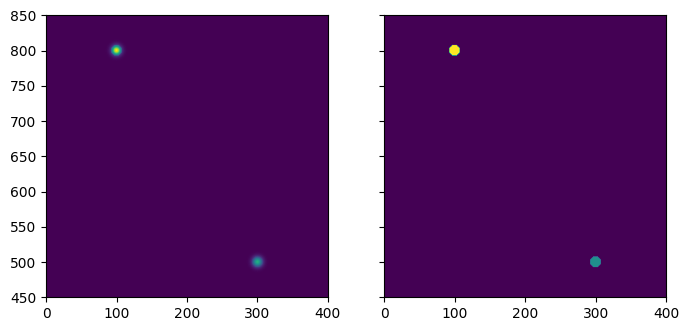

In [4]:
# Show the image and segmentation map
fig,(p1,p2) = plt.subplots(1,2,figsize=(8,8),sharex=True,sharey=True)
p1.imshow(full_img,origin='lower')
p2.imshow(segmap,origin='lower')
plt.xlim(0,400)
plt.ylim(450,850)

In [ ]:
# This is the config file for the grism simulation
'''
INSTRUMENT ROMAN 
CAMERA IR
SCIENCE_EXT SCI ; Science extension
DQ_EXT DQ
ERRORS_EXT ERR
DQMASK 16383
RDNOISE 0.0
EXPTIME EXPTIME
POBJSIZE 1.0
SMFACTOR 1.0
DRZRESOLA 10.764
DRZSCALE 0.110
DRZLAMB0 12850.0
#DRZXINI 15.0
#DRZROOT aXeWFC3
TELAREA 45238.93

# First order (BEAM A) 
# BEAMA and DLDP assume spectrum is centered on the imaging position
BEAMA -800 800
MMAG_EXTRACT_A 30
MMAG_MARK_A 30

#
# Trace description
DYDX_ORDER_A 2
DYDX_A_0 	66.4449  -0.00579476   -0.0124014      0.00000 -1.86114e-08      0.00000 
DYDX_A_1    -0.0125705 -8.97764e-07  2.83491e-06      0.00000  2.07533e-10      0.00000
DYDX_A_2  -7.68463e-07  3.99010e-11  2.54744e-10      0.00000 -2.19269e-14      0.00000

#
# X and Y Offsets
#
XOFF_A 0.0
YOFF_A 0.0

#
# Dispersion solution
#
DISP_ORDER_A 2
DLDP_A_0       16142.1    -0.115115   -0.0635720      0.00000 -3.98700e-06      0.00000
DLDP_A_1      -10.9977  6.65564e-05 -6.39743e-06      0.00000  1.27897e-10      0.00000
DLDP_A_2  -3.10835e-05  6.03563e-09  1.17572e-09      0.00000 -4.74624e-13      0.00000


SENSITIVITY_A sens_0720_2020.fits
'''

In [5]:
# Simulate grism image with flat sed model
sim_roman = grizli.model.GrismFLT(grism_file='roman_example_flt.fits', 
                                  ref_file='roman_grism_test_dirimg.fits', 
                                  seg_file='roman_grism_test_segmap.fits',
                                  pad=(2000,2000))

sim_roman.compute_full_model(ids=[1,2], mags=[21,20.5], verbose=True)

Image cutout: x=slice(0, 1024, None), y=slice(0, 1024, None) [Out of range]
roman_example_flt.fits / blot reference roman_grism_test_dirimg.fits[0]
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 1024, None), y=slice(0, 1024, None) [Out of range]
roman_example_flt.fits / Pad ref HDU with 4064 pixels
roman_example_flt.fits / blot segmentation roman_grism_test_segmap.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordi

2it [00:00, 35.01it/s]


########################################## 
# ! Exception (2023-09-15 05:59:31.048)
#
# !Traceback (most recent call last):
# !  File "/hpc/group/cosmology/zg64/miniconda3/envs/grizli39/lib/python3.9/site-packages/grizli/model.py", line 419, in process_config
# !    self.flat_index = self.idx[dyc + self.x0[0], self.dxpix]
# !IndexError: index 93 is out of bounds for axis 0 with size 52
# !
# !During handling of the above exception, another exception occurred:
# !
# !Traceback (most recent call last):
# !  File "/hpc/group/cosmology/zg64/miniconda3/envs/grizli39/lib/python3.9/site-packages/grizli/model.py", line 3148, in compute_model_orders
# !    beam = GrismDisperser(id=id,
# !  File "/hpc/group/cosmology/zg64/miniconda3/envs/grizli39/lib/python3.9/site-packages/grizli/model.py", line 289, in __init__
# !    self.process_config()
# !IndexError
# !
######################################### 



########################################## 
# ! Exception (2023-09-15 05:59:31.074)
#
# !Tr